# 1-1 Example: Modeling Procedure for Structured Data

### 1. Data Preparation


The purpose of the Titanic dataset is to predict whether the given passengers could be survived after Titinic hit the iceburg titanic, according to their personal information.

We usually use DataFrame from the pandas library to pre-process the structured data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


Introduction of each field：

* Survived: 0 for death and 1 for survived [y labels]
* Pclass: Class of the tickets, with three possible values (1,2,3) [converting to one-hot encoding]
* Name: Name of each passenger [discarded]
* Sex: Gender of each passenger [converting to bool type]
* Age: Age of each passenger (partly missing) [numerical feature, should add "Whether age is missing" as auxiliary feature]
* SibSp: Number of siblings and spouse of each passenger (interger) [numerical feature]
* Parch: Number of parents/children of each passenger (interger) [numerical feature]
* Ticket: Ticket number (string) [discarded]
* Fare: Ticket price of each passenger (float, between 0 to 500) [numerical feature]
* Cabin: Cabin where each passenger is located (partly missing) [should add "Whether cabin is missing" as auxiliary feature]
* Embarked: Which port was each passenger embarked, possible values are S、C、Q (partly missing) [converting to one-hot encoding, four dimensions, S,C,Q,nan]

Use data visualization in pandas library for initial EDA (Exploratory Data Analysis).

Survival label distribution:

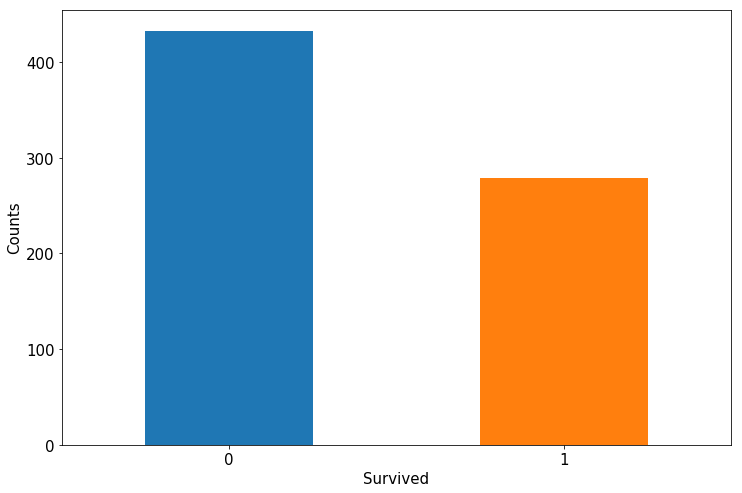

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

Age distribution:

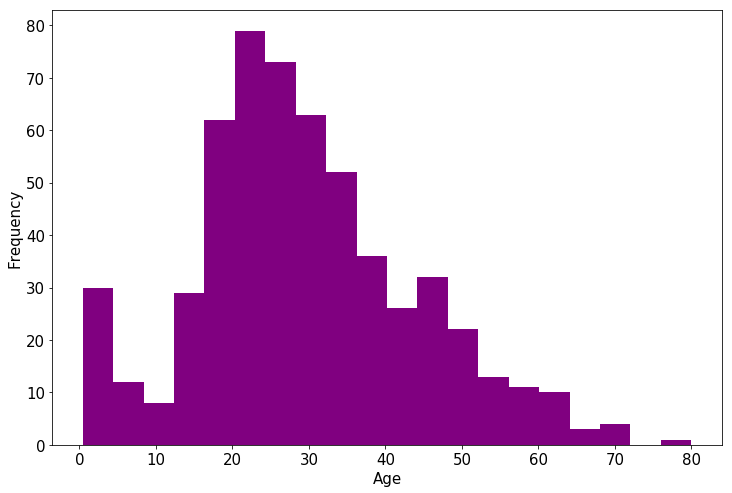

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

Correlation between age and survival label:

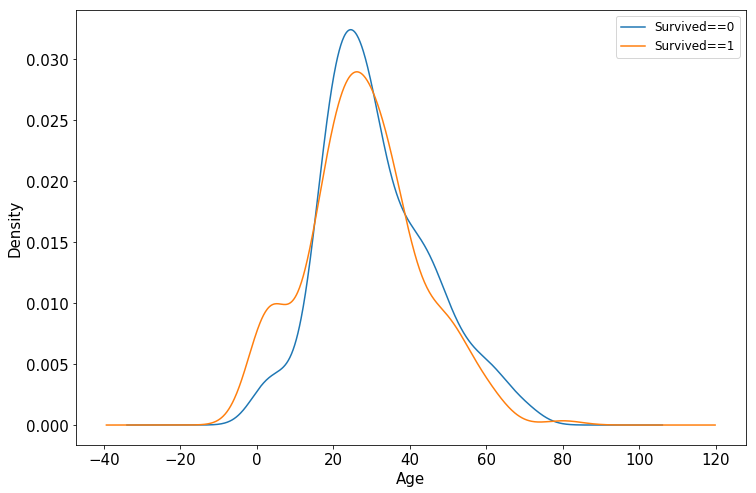

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

Below are code for formal data pre-processing:

In [5]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


### 2. Model Definition

Usually there are three ways of modeling using APIs of Keras: sequential modeling using Sequential() function, arbitrary modeling using API functions, and customized modeling by inheriting base class Model.

Here we take the simplest way: sequential modeling using function Sequential().

In [6]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


### 3. Model Training

There are three usual ways for model training: use internal function fit, use internal function train_on_batch, and customized training loop. Here we introduce the simplist way: using internal function fit.

In [7]:
# Use binary cross entropy loss function for binary classification
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #Split part of the training data for validation
            )

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 1ms/sample - loss: 1.4187 - AUC: 0.5983 - val_loss: 1.0932 - val_AUC: 0.6050
Epoch 2/30
569/569 [==============================] - 0s 46us/sample - loss: 0.8293 - AUC: 0.6839 - val_loss: 0.9167 - val_AUC: 0.6453
Epoch 3/30
569/569 [==============================] - 0s 44us/sample - loss: 0.7604 - AUC: 0.7139 - val_loss: 0.8633 - val_AUC: 0.6571
Epoch 4/30
569/569 [==============================] - 0s 51us/sample - loss: 0.6946 - AUC: 0.7337 - val_loss: 0.7408 - val_AUC: 0.6626
Epoch 5/30
569/569 [==============================] - 0s 49us/sample - loss: 0.6157 - AUC: 0.7415 - val_loss: 0.6497 - val_AUC: 0.6766
Epoch 6/30
569/569 [==============================] - 0s 45us/sample - loss: 0.5693 - AUC: 0.7686 - val_loss: 0.6168 - val_AUC: 0.7059
Epoch 7/30
569/569 [==============================] - 0s 49us/sample - loss: 0.5534 - AUC: 0.7911 - val_loss: 0.5990 - val_AUC: 0.7282
Epoch 8/30

### 4. Model Evaluation

First, we evaluate the model performance on the training and validation datasets.

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

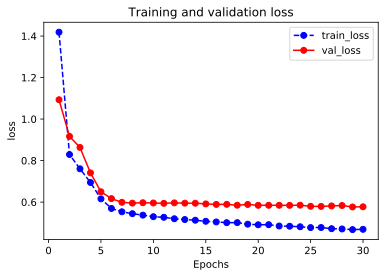

In [9]:
plot_metric(history,"loss")

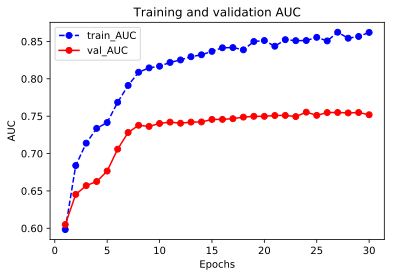

In [10]:
plot_metric(history,"AUC")

Let's take a look at the performance on the testing dataset.

In [11]:
model.evaluate(x = x_test,y = y_test)

179/179 [==============================] - 0s 41us/sample - loss: 0.4680 - AUC: 0.8473


[0.46800280533023386, 0.84729064]


### 5. Model Application

In [12]:
#Predict the possiblities
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #Identical way

array([[0.23322472],
       [0.44866276],
       [0.45421314],
       [0.90452284],
       [0.47994092],
       [0.6177022 ],
       [0.14264145],
       [0.721036  ],
       [0.56427395],
       [0.1562463 ]], dtype=float32)

In [13]:
#Predict the classes
model.predict_classes(x_test[0:10])

array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

### 6. Model Saving


The trained model could be saved through either the way of Keras or the way of original TensorFlow. The former only allows using Python to retrieve the model, while the latter allows cross-platform deployment.

The latter way is recommended to save the model.

**(1) Model Saving with Keras**

In [14]:
# Saving model structure and parameters

model.save('./data/keras_model.h5')  

del model  #Deleting current model

# Identical to the previous one
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)

179/179 [==============================] - 0s 799us/sample - loss: 0.4680 - AUC: 0.8473


[0.46800280533023386, 0.84729064]

In [15]:
# Saving the model structure
json_str = model.to_json()

# Retrieving the model structure
model_json = models.model_from_json(json_str)

In [16]:
# Saving the weights of the model
model.save_weights('./data/keras_model_weight.h5')

# Retrieving the model structure
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# Load the weights
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

179/179 [==============================] - 0s 799us/sample - loss: 0.4680 - AUC: 0.8473


[0.46800280533023386, 0.84729064]

**(2) Model Saving with Original Way of TensorFlow**

In [18]:
# Saving the weights, this way only save the tensors of the weights
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

In [19]:
# Saving model structure and parameters to a file, so the model allows cross-platform deployment

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.
179/179 [==============================] - 0s 1ms/sample - loss: 0.4680 - AUC: 0.8473


[0.46800260836851665, 0.84729064]